In [1]:
import os
import re
import json
import math
import time
import demoji
import curlify
import requests
import pandas as pd

import pickle
from scipy.special import softmax

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from tqdm.notebook import tqdm

all_stopwords = stopwords.words('english')
pd.set_option('display.max_colwidth', None)

bearer_token = "AAAAAAAAAAAAAAAAAAAAADSXjAEAAAAAQ32sCpTWcilVX%2BQj0BjOArOSYCE%3DUax6ZCizLRwwQcWQirExGQEDEB903dxBZKM4LAuGTMTvMa4jVP"

from datetime import date

today = date.today()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/crarojasca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
SCRAP_CTTS = True
SCRAP_DENIALS = True

## Functions

In [3]:
s = requests.Session()
def getTweets(query, max_results=None, next_token=None):
    # Twitter Endpoint
    url = "https://api.twitter.com/2/tweets/search/recent"
    
    # Auth Bearer no research access or premium for the moment
    headers = {
        "Authorization": "Bearer {}".format(bearer_token)
    }
    
    # Query parameters
    params = {
        'query': query,
    #     'start_time': start_date,
    #     'end_time': end_date,
        'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
        'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
        'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
        'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
        'next_token': {}
    }
    if max_results: params['max_results'] = max_results
    if next_token: params['next_token'] = next_token

    try:
        time.sleep(6)
        req = requests.Request(
            "GET",
            url,
            params=params,
            headers=headers
        ).prepare()

        response = s.send(req)
        results = json.loads(response.text)
        return results
    except:
        print(json.loads(response.text))

def getUser(username):
    # User Endpoint 
    url = "https://api.twitter.com/2/users/by/username/" + username
    # Auth Bearer no research access or premium for the moment
    headers = {
        "Authorization": "Bearer {}".format(bearer_token)
    }

    params = {
        'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
        'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
        'next_token': {}
    }
    
    time.sleep(1)
    try:
        req = requests.Request(
            "GET",
            url,
            params=params,
            headers=headers
        ).prepare()

        response = s.send(req)
        results = json.loads(response.text)["data"]

        return json.loads(response.text)["data"]
    except:
        print(json.loads(response.text)["errors"][0]["detail"])


def count_tweets(query):
    # User Endpoint 
    url = "https://api.twitter.com/2/tweets/counts/recent"
    # Auth Bearer no research access or premium for the moment
    headers = {
        "Authorization": "Bearer {}".format(bearer_token)
    }

    params = {
        "query": query,
        "granularity": "day"
    }

    time.sleep(1)
    req = requests.Request(
        "GET",
        url,
        params=params,
        headers=headers
    ).prepare()

    response = s.send(req)
    results = json.loads(response.text)
    return results["meta"]["total_tweet_count"]
    
    
def extract_data(query, max_result=100):
    data = pd.DataFrame()

    # Scrap all the data up to the last page
    next_token = None

    n_tweets = count_tweets(query)
    if n_tweets==0:
        return data
    
    #
    pbar = tqdm(total=math.ceil(n_tweets/max_result))
    while True:
        pbar.update(1)
        try:
            results = getTweets(query=query, max_results=max_result, next_token=next_token)
            data = pd.concat([data, pd.DataFrame(results["data"])], ignore_index=True)
            if not "next_token" in results["meta"]:
                break
            next_token = results["meta"]["next_token"] 
        except:
            print(results)
            break
    pbar.close()
    
    # Reordering de columns
    columns = list(data.columns)
    columns.remove("text")
    columns.remove("public_metrics")
    data = data[["text", "public_metrics"] + columns]
    return data

def preprocess_text(text):
    # Lower
    preprocessed_text = text.lower()
    # Remove Handle
    preprocessed_text = re.sub("@\w+", "", preprocessed_text)
    # Remove Hashtag
    preprocessed_text = re.sub("#\w+", "", preprocessed_text)
    # Remove Links
    preprocessed_text = re.sub(r'http[s]?:\S+', '', preprocessed_text, flags=re.MULTILINE)
    # Remove emotes 
    preprocessed_text = demoji.replace(preprocessed_text, "")
    # Remove new line
    preprocessed_text = re.sub("\\n", "", preprocessed_text)
    # Remove extra spaces 
    preprocessed_text = preprocessed_text.strip()
    
    return preprocessed_text

def get_data(query):
    results = extract_data(query)
    results["preprocessed_text"] = results["text"].apply(preprocess_text)
    results = results.sort_values(by="created_at", ascending=False)
    results = results.drop_duplicates(subset=['text'], keep='last')
    results = results[(results.preprocessed_text!="")].copy(deep=True)
    return results

## ClimateScam
### Original Page

In [4]:
results = get_data("from:ClimateScam")
print(results.shape)
results[["preprocessed_text", "text", "public_metrics"]]

  0%|          | 0/1 [00:00<?, ?it/s]

(7, 12)


,preprocessed_text,text,public_metrics
0,press coverage of the tragic whale deaths is an attempt to exonerate offshore wind development. sonar blasting is killing whales indirectly by inducing deafness &amp; deadly behavior. more whales have found themselves in the path of more ships. whales aren't born deaf.,Press coverage of the tragic whale deaths is an attempt to exonerate offshore wind development. Sonar blasting is killing whales indirectly by inducing deafness &amp; deadly behavior. More whales have found themselves in the path of more ships. Whales aren't born deaf. #climatescam,"{'retweet_count': 24, 'reply_count': 4, 'like_count': 72, 'quote_count': 2, 'impression_count': 1522}"
1,"love the plymouth rock story. 400 + years since the pilgrims &amp; it's still there, not underwater, reminding people to go down the block &amp; see where bert's restaurant got flooded out by a nor'easter. bert's had good food but didn't survive the storm. plymouth rock did.","@MOLLYMMMMMMMMMM Love the Plymouth Rock story. 400 + years since the Pilgrims &amp; it's still there, not underwater, reminding people to go down the block &amp; see where Bert's Restaurant got flooded out by a Nor'easter. Bert's had good food but didn't survive the storm. Plymouth Rock did. #climatescam","{'retweet_count': 1, 'reply_count': 1, 'like_count': 0, 'quote_count': 0, 'impression_count': 57}"
2,the washington post asserted that climate change had reduced colorado river flow &amp; was drying up reservoirs like lake powell &amp; lake mead. the river's inflows haven't changed since 1895. these levels &amp; flow issues are due to overuse. wapo people want $. scam!,The Washington Post asserted that climate change had reduced Colorado River flow &amp; was drying up reservoirs like Lake Powell &amp; Lake Mead. The River's inflows haven't changed since 1895. These levels &amp; flow issues are due to overuse. WAPO people want $. SCAM! #climatescam,"{'retweet_count': 24, 'reply_count': 9, 'like_count': 85, 'quote_count': 1, 'impression_count': 2136}"
3,"july 2021: london got a month’s rain in 3 hours. 2 weeks later, it happened again. the univ. of bristol blamed climate change &amp; predicted 100 years of floods. nov. 2022: they said ""due to co2 emissions, the uk &amp; the globe have increased hot, dry conditions."" really?","July 2021: London got a month’s rain in 3 hours. 2 weeks later, it happened again. The Univ. of Bristol blamed climate change &amp; predicted 100 years of floods. Nov. 2022: they said ""Due to CO2 emissions, the UK &amp; the globe have increased hot, dry conditions."" Really? #climatescam","{'retweet_count': 22, 'reply_count': 7, 'like_count': 62, 'quote_count': 1, 'impression_count': 6388}"
4,"texas leads the u.s. with wind power, is 2nd with solar capacity, &amp; is adding grid-scale batteries faster than any state (ex ca). new plants must prove that they add to the network. tx permits quickly, but renewables cost $. the price for guarantees = + $3 bil. ouch!","Texas leads the U.S. with wind power, is 2nd with solar capacity, &amp; is adding grid-scale batteries faster than any state (ex CA). New plants must prove that they add to the network. TX permits quickly, but renewables cost $. The price for guarantees = + $3 Bil. Ouch! #climatescam","{'retweet_count': 5, 'reply_count': 5, 'like_count': 25, 'quote_count': 0, 'impression_count': 1016}"
5,"exxon announced biofuel is out, leaving carbon capture &amp; storage (ccs) as the “green” strategy at exxonmobil. reason: algae doesn't work. the end of algae as a crude oil substitute comes after $350 million &amp; 14 years of commitment. exxon is committed to oil &amp; gas.","Exxon announced Biofuel is out, leaving carbon capture &amp; storage (CCS) as the “green” strategy at ExxonMobil. Reason: algae doesn't work. The end of algae as a crude oil substitute comes after $350 million &amp; 14 years of commitment. Exxon is committed to oil &amp; gas. #climatescam","{'retweet_count': 17, 'reply_count':

### Complete lines

In [5]:
climate_scam_handle = get_data("@ClimateScam OR #ClimateScam OR from:ClimateScam -is:retweet")
print(climate_scam_handle.shape)
climate_scam_handle[["preprocessed_text", "text", "public_metrics"]].head()

  0%|          | 0/358 [00:00<?, ?it/s]

(10702, 14)


,preprocessed_text,text,public_metrics
17,"""they owned nothing, and yet they were happier than they had ever been before."" stop","""They owned nothing, and yet they were happier than they had ever been before."" 🤡\n\nStop #digital #enslavement🤡\n\n#CrimesAgainstHumanity\n\n#TheNewWorldOrder #GreatReset #Control #Power #Economy #ClimateScam #WEFpuppets #STOP #CBDCs #UkraineTerror #GruenerMist #Bitcoin #Crypto https://t.co/qh5dSlvPz3","{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 17}"
25,rt : new climate news: new study deepens understanding of present-day changes in earth's environmental systems -- sciencedail…,RT @HavaClimate: New Climate News: \n\nNew study deepens understanding of present-day changes in Earth's environmental systems -- ScienceDail…,"{'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 0}"
29,new climate news: new study deepens understanding of present-day changes in earth's environmental systems -- sciencedaily,New Climate News: \n\nNew study deepens understanding of present-day changes in Earth's environmental systems -- ScienceDaily\n\n#climatecrisis #climateaction #esg #carbon #sustainability #netzero #climatescam #globalwarming #climatechange\nhttps://t.co/3Ob3QdF5WY,"{'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 4}"
37,rt : nothing but insults from the king of climate bull crap. no evidence just fear mongering porn. what a pathet…,RT @randyhorst3: @GeraldKutney Nothing but insults from the king of climate bull crap. No evidence just fear mongering porn. What a pathet…,"{'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 0}"
40,nothing but insults from the king of climate bull crap. no evidence just fear mongering porn. what a pathetic lying liberal paid propaganda mouthpiece. show your evidence climate preacher.,@GeraldKutney Nothing but insults from the king of climate bull crap. No evidence just fear mongering porn. What a pathetic lying liberal paid propaganda mouthpiece. Show your evidence climate preacher. #ClimateScam https://t.co/TyZrL5hDgE,"{'retweet_count': 1, 'reply_count': 0, 'like_count': 1, 'quote_count': 0, 'impression_count': 37}"


In [6]:
climate_scam_hashtag = get_data("#ClimateScam -is:retweet")
print(climate_scam_hashtag.shape)

  0%|          | 0/73 [00:00<?, ?it/s]

(5648, 13)


In [7]:
climate_scam_hashtag[["preprocessed_text", "text", "public_metrics"]].sample(5)

,preprocessed_text,text,public_metrics
1102,"to all the below morons who believed a kid who barely went to school…. you have all been hypnotised and followed, are still following the great climate hoax!wake up!","#ClimateCult #ClimateScam \n\nTo all the below morons who believed a kid who barely went to school….\n#ClimateAction \n#ClimateCrisis \n#ClimateCatastrophe \n#ClimateEmergency \n\nYou have all been hypnotised and followed, are still following the great climate hoax!\n\nWake up! https://t.co/P4pUMyDzSX","{'retweet_count': 1, 'reply_count': 0, 'like_count': 1, 'quote_count': 0, 'impression_count': 68}"
3104,let's see how many celebrities grab their phone and scream climate change! we all know climate change is just a for the elites,@NWS Let's see how many celebrities grab their phone and scream climate change! \nWe all know climate change is just a #ClimateScam #MoneyGrab for the elites,"{'retweet_count': 1, 'reply_count': 2, 'like_count': 1, 'quote_count': 0, 'impression_count': 85}"
6261,as you stated “our house is on fire” you are right it is all the gaslighting all your is doing. .,@Laurel_BC @NDP As you stated “Our house is on fire” you are right it is all the gaslighting all your #misinformation is doing. #ClimateScam #HAARP.,"{'retweet_count': 2, 'reply_count': 0, 'like_count': 3, 'quote_count': 0, 'impression_count': 102}"
5772,"3) whilst it has deplorable conditions and requires changes, not only in the way the pursuit for cheeper food to feed the animals, has lead to animals that produce meat products that no longer contain nutrients and vitamins -","@Greenpeace 3)\n#ClimateEmergency #ClimateEducation #ClimateScam \nwhilst it has deplorable conditions and requires changes, not only in the way the pursuit for cheeper food to feed the animals, has lead to animals that produce meat products that no longer contain nutrients and vitamins -","{'retweet_count': 0, 'reply_count': 1, 'like_count': 0, 'quote_count': 0, 'impression_count': 20}"
3249,"it is march 10, 2023 and i am still looking for a downside to the planet returning to its more typical warmer climate.","#ClimateJustice #ClimateEmergency #ClimateCrisis #ClimateAction #ClimateStrike #ClimateScam #Climate It is March 10, 2023 and I am STILL looking for a downside to the planet returning to its more typical warmer climate.","{'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 40}"


In [8]:
def count_words(col):    
    df = col.str.split(expand=True).stack().value_counts().reset_index()
    df.columns = ['Word', 'Frequency'] 
    df = df[~df["Word"].str.lower().isin(all_stopwords)]
    return df

count_words(climate_scam_hashtag.text)[:30]

,Word,Frequency
0,#ClimateScam,4853
12,climate,689
17,#climatescam,514
28,#WEF,383
31,#Agenda2030,361
35,&amp;,336
37,#GreatReset,318
38,Climate,316
39,@MikeHudema,310
41,#ClimateEmergency,286


## CTTs
### Extracting
#### Users

In [9]:
ctts = pd.read_csv("../CTTs/ctt_twitter_handles.csv")
ctts

,screen_name,Followers,Type,Name
0,capitalresearch,5023,CTT,Capital Research Center
1,ceidotorg,12565,CTT,Competitive Enterprise Institute
2,NationalCenter,7807,CTT,National Center for Public Policy Research
3,ReasonFdn,7030,CTT,Reason Foundation
4,ACSHorg,5734,CTT,American Council on Science and Health
5,AEI,151109,CTT,American Enterprise Institute
6,CatoInstitute,362920,CTT,CATO Institute
7,CFACT,13985,CTT,CFACT
8,FoF_Liberty,236,CTT,Frontiers of Freedom
9,FraserInstitute,31658,CTT,Fraser Institute


In [10]:
for i in range(ctts.shape[0]):
    username = ctts.loc[i].screen_name
    user_meta = getUser(username)
    ctts.loc[i, 'followers_count'] = user_meta['public_metrics']['followers_count']
    ctts.loc[i, 'following_count'] = user_meta['public_metrics']['following_count']
    ctts.loc[i, 'tweet_count'] = user_meta['public_metrics']['tweet_count']
    ctts.loc[i, 'listed_count'] = user_meta['public_metrics']['listed_count']
    ctts.loc[i, 'description'] = user_meta['description']
    ctts.loc[i, 'id'] = user_meta['id']
    ctts.loc[i, 'verified'] = user_meta['verified']
    ctts.loc[i, 'created_at'] = user_meta['created_at']
ctts

,screen_name,Followers,Type,Name,followers_count,following_count,tweet_count,listed_count,description,id,verified,created_at
0,capitalresearch,5023,CTT,Capital Research Center,5636.0,3115.0,8992.0,117.0,"Capital Research Center is America's Investigative Think Tank, covering all the influencers in our politics.",18957839,False,2009-01-13T23:07:06.000Z
1,ceidotorg,12565,CTT,Competitive Enterprise Institute,13020.0,3461.0,30537.0,586.0,"CEI is a non-profit public policy organization dedicated to advancing the principles of limited government, free enterprise, and individual liberty.",15471040,True,2008-07-17T17:49:08.000Z
2,NationalCenter,7807,CTT,National Center for Public Policy Research,8057.0,6401.0,23367.0,200.0,"The National Center for Public Policy Research is a nonpartisan, free-market conservative think-tank. Home of @Project21News & @FreeEntProject.",19384480,False,2009-01-23T06:38:46.000Z
3,ReasonFdn,7030,CTT,Reason Foundation,8967.0,98.0,6301.0,139.0,Reason Foundation is a nonprofit dedicated to advancing free minds and free markets. @ReasonFdn produces respected public policy research and publishes @reason.,1177334131732156420,True,2019-09-26T21:29:18.000Z
4,ACSHorg,5734,CTT,American Council on Science and Health,6010.0,752.0,4725.0,230.0,American Council on Science and Health. Science and consumer advocates since 1978. We separate facts from myths and debunk junk science.,195858764,True,2010-09-27T19:03:58.000Z
5,AEI,151109,CTT,American Enterprise Institute,161131.0,1397.0,68243.0,2953.0,Independent research driving the national conversation.,30864583,True,2009-04-13T13:33:33.000Z
6,CatoInstitute,362920,CTT,CATO Institute,367500.0,7021.0,98625.0,8499.0,"A public policy research organization dedicated to individual liberty, limited government, free markets, and peace.",15450996,True,2008-07-16T05:46:16.000Z
7,CFACT,13985,CTT,CFACT,14612.0,4586.0,11258.0,324.0,"CFACT defends the environment & human welfare through facts, news, and analysis, promoting free-market solutions to the world's environmental problems.",38532025,False,2009-05-07T22:20:56.000Z
8,FoF_Liberty,236,CTT,Frontiers of Freedom,305.0,520.0,2196.0,7.0,"Standing for Individual freedom, peace by strength, limited government, free markets, and traditional American values.",2464808161,False,2014-04-26T15:48:58.000Z
9,FraserInstitute,31658,CTT,Fraser Institute,33188.0,1096.0,15647.0,1048.0,#1 rated think tank in 🇨🇦! Improving the lives of Canadians with high-quality timely research and innovative outreach.,23529233,False,2009-03-10T00:18:34.000Z


In [11]:
## Total Tweets
ctts.tweet_count.sum()

694063.0

#### Tweets

In [12]:
handles_process = ctts.screen_name.unique()
    
total_sum = 0
for username in tqdm(handles_process):
    number = count_tweets("@{} -is:retweet".format(username))
    total_sum+=number
print("Number of tweets: {}".format(total_sum))
print("Aproximate time to process: {} minutes".format(total_sum*6/60/100))

  0%|          | 0/17 [00:00<?, ?it/s]

Number of tweets: 7572
Aproximate time to process: 7.572 minutes


In [14]:
if SCRAP_CTTS:
    file = "../Twitter_scrapped/CTTs/tweets_scrapped-CTTs_{}.csv".format(today)
    if os.path.isfile(file):
        tweets = pd.read_csv(file)
        handles_process = list(set(ctts.screen_name.unique()) - set(tweets.username.unique()))
    else:
        tweets = pd.DataFrame()
        handles_process = ctts.screen_name.unique()

    for username in tqdm(handles_process):
        handle_tweets = extract_data("@{} -is:retweet".format(username), 100)
        handle_tweets["username"] = username
        tweets = pd.concat([tweets, handle_tweets])
        tweets.to_csv(file, index=False)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Preprocess

In [25]:
file = "../Twitter_scrapped/CTTs/tweets_scrapped-CTTs_{}.csv".format(today)
tweets = pd.read_csv(file)

In [26]:
tweets["preprocessed_text"] = tweets["text"].apply(preprocess_text)

In [27]:
real_tweets = tweets[tweets.referenced_tweets.isna() & (tweets.preprocessed_text!="")].copy(deep=True)
print("Number of tweets: {} from {} to {}.".format(
    real_tweets.shape[0],
    tweets.created_at.min(),
    tweets.created_at.max()
))

Number of tweets: 767 from 2023-03-06T01:45:30.000Z to 2023-03-13T01:46:38.000Z.


In [28]:
count_words(tweets.text)[:30]

,Word,Frequency
1,@Heritage,3085
6,@FreedomWorks,1852
11,@CatoInstitute,1150
14,@Jim_Jordan,828
15,@DailySignal,817
16,@TimKennedyJr1,792
34,&amp;,384
35,@RepAndyBiggsAZ,372
36,like,365
41,@HudsonInstitute,329


## Deniers
### Extracting
#### Users

In [29]:
denials = pd.read_csv("../CTTs/denier_twitter_handles.csv")
for i in range(denials.shape[0]):
    username = denials.loc[i].screen_name
    user_meta = getUser(username)
    if not user_meta:
        continue
    denials.loc[i, 'exist'] = True
    denials.loc[i, 'followers_count'] = user_meta['public_metrics']['followers_count']
    denials.loc[i, 'following_count'] = user_meta['public_metrics']['following_count']
    denials.loc[i, 'tweet_count'] = user_meta['public_metrics']['tweet_count']
    denials.loc[i, 'listed_count'] = user_meta['public_metrics']['listed_count']
    denials.loc[i, 'description'] = user_meta['description']
    denials.loc[i, 'id'] = user_meta['id']
    denials.loc[i, 'verified'] = user_meta['verified']
    denials.loc[i, 'created_at'] = user_meta['created_at']
denials

User has been suspended: [PolitixGal].
User has been suspended: [JWSpry].
User has been suspended: [IceAgeFarmer].
Could not find user with username: [TimNBCBoston].
User has been suspended: [MooseMan1956].
User has been suspended: [Over400ppm].
User has been suspended: [ChrisJC12002].
User has been suspended: [OverTheMoonbat].
User has been suspended: [LearnFromNature].
Could not find user with username: [SimonPearson961].
User has been suspended: [RuffusMD].
User has been suspended: [jenninemorgan].
Could not find user with username: [dbirch214].
User has been suspended: [2013Boodicca].
User has been suspended: [BrexitKite].
Could not find user with username: [RogerAPielkeSr].
User has been suspended: [peden_c].
User has been suspended: [Natalia01Mateo].
User has been suspended: [NoTricksZone].
User has been suspended: [NoTricksZone].
User has been suspended: [BulldogLoyalty].
User has been suspended: [BulldogLoyalty].
User has been suspended: [AyesHavit].
User has been suspended: [L

,screen_name,Followers,Type,exist,followers_count,following_count,tweet_count,listed_count,description,id,verified,created_at
0,EcoSenseNow,107212.0,Climate Denier,True,144594.0,1454.0,48706.0,1214.0,"BSc Biology PhD Ecology, Greenpeace co-founder, Now a Sensible Environmentalist. Director https://t.co/lfVMUTLFbi. Science & logic, not sensation & fear. CelebrateCO2!",1392956425,False,2013-04-30T20:03:19.000Z
1,ShellenbergerMD,98407.0,Climate Denier,True,603098.0,821.0,23728.0,3765.0,"Pro-civilization : Time, ""Hero of the Environment"" : Bestselling author of ""Apocalypse Never"" & ""San Fransicko"" : Green Book Award : MD = my initials. Not a doc",2474749586,True,2014-05-03T01:10:35.000Z
2,RyanMaue,94377.0,Climate Denier,True,101134.0,5005.0,10284.0,3127.0,Meteorologist | PhD Florida State #GoNoles 🏖 | Michigan #GoBlue | Look Up 🚀 | Follow the data science | Energy & Agriculture Weather | Forecast Company,16117029,True,2008-09-03T18:27:32.000Z
3,PolitixGal,93040.0,Climate Denier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,catoletters,81717.0,Climate Denier,True,81286.0,27392.0,478170.0,899.0,"Voluntary Cooperation/Exchange; Human choice is the foundation of liberty. Read Rothbard and Mises. Peace NAP. End the Fed. Parody, I am not Cato The Younger",15063486,False,2008-06-09T18:11:35.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...
230,Apiglobal,3000.0,Climate Denier-Trade Assoc,True,3443.0,690.0,3345.0,90.0,API Global Industry Services (GIS) provides oil and gas professionals with resources necessary to advance safety and efficiency. @DieselMatters @MotorOilMatters,2885823443,False,2014-11-20T16:58:38.000Z
231,Chamberglobal,2263.0,Climate Denier-Trade Assoc,True,3178.0,227.0,3764.0,73.0,"The @USChamber's International Affairs Division advocates for free enterprise, competitive markets, and rules-based #trade and #investment.",1183621296,False,2013-02-15T19:55:20.000Z
232,NationalMining,1640.0,Climate Denier-Trade Assoc,True,2835.0,1877.0,4361.0,48.0,The National Mining Association (NMA) is the only national trade organization that serves as the voice of U.S. mining.,2422372057,False,2014-04-01T16:45:35.000Z
233,OfficialWSPA,1551.0,Climate Denier-Trade Assoc,True,1854.0,509.0,978.0,31.0,"Official account for the Western States Petroleum Association, dedicated to ensuring continued access to reliable, affordable and sustainable energy for all",615493717,False,2012-06-22T20:12:37.000Z


In [30]:
print("{} in total {}.".format((denials.exist==True).sum(), denials.shape[0]))

191 in total 235.


#### Tweets

In [31]:
handles_process = denials[denials.exist==True].screen_name.unique()
    
total_sum = 0
for username in tqdm(handles_process):
    number = count_tweets("from:{} -is:retweet".format(username))
    total_sum+=number
print("Number of tweets: {}".format(total_sum))
print("Aproximate time to process: {} minutes".format(total_sum*6/60/100))

  0%|          | 0/186 [00:00<?, ?it/s]

Number of tweets: 11073
Aproximate time to process: 11.073 minutes


In [32]:
denials_file = "../Twitter_scrapped/deniers/{}.csv".format(today)
denials_to_process = denials[denials.exist==True]
if SCRAP_DENIALS:
    if os.path.isfile(denials_file):
        tweets_denials = pd.read_csv(denials_file)
        handles_process = list(
            set(denials_to_process.screen_name.unique()) - set(tweets_denials.username.unique()))
    else:
        tweets_denials = pd.DataFrame()
        handles_process = denials_to_process.screen_name.unique()

    for username in tqdm(handles_process):
        handle_tweets = extract_data("from:{} -is:retweet".format(username), 100)
        handle_tweets["username"] = username
        tweets_denials = pd.concat([tweets, handle_tweets])
        tweets_denials.to_csv(file, index=False)

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
tweets_denials.sample(5)

,text,public_metrics,created_at,id,conversation_id,edit_history_tweet_ids,reply_settings,lang,in_reply_to_user_id,author_id,referenced_tweets,username,geo,withheld,preprocessed_text
5950,@Heritage_Action @Heritage You clowns are so stupid that you think everyone else is stupid and that they will fall for this childish guilt by association.,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 35}",2023-03-10T20:23:41.000Z,1.634289e+18,1.634267e+18,['1634288938864222209'],everyone,en,1.306002e+08,1.315013e+09,"[{'type': 'replied_to', 'id': '1634266863659040768'}]",Heritage,NaN,NaN,you clowns are so stupid that you think everyone else is stupid and that they will fall for this childish guilt by association.
6188,"@Robertaannoyed @Heritage I wish it was just the tax issue… they lie, hate, divide, and are bigotted group that has worked hard to end our democratic republic with gerrymandering and voter suppression laws at state levels. Hate heritage","{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 3}",2023-03-09T19:23:50.000Z,1.633911e+18,1.633909e+18,['1633911489286270977'],everyone,en,9.248828e+17,1.752025e+07,"[{'type': 'replied_to', 'id': '1633910607815622658'}]",Heritage,NaN,NaN,"i wish it was just the tax issue… they lie, hate, divide, and are bigotted group that has worked hard to end our democratic republic with gerrymandering and voter suppression laws at state levels. hate heritage"
3066,"@FreedomWorks @Jim_Jordan I really don't understand all this grandstanding.\nThese Republicans are now acting like COVID is a deadly virus that kills people.\nFor three years, Republicans told us that COVID was a hoax.","{'retweet_count': 11, 'reply_count': 1, 'like_count': 49, 'quote_count': 0, 'impression_count': 314}",2023-03-09T12:56:29.000Z,1.633814e+18,1.633521e+18,['1633814009219543041'],everyone,en,1.473089e+07,1.060548e+18,"[{'type': 'replied_to', 'id': '1633520681211293697'}]",FreedomWorks,NaN,NaN,"i really don't understand all this grandstanding.these republicans are now acting like covid is a deadly virus that kills people.for three years, republicans told us that covid was a hoax."
4517,@Heritage This is your daily reminder to fck off,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0, 'impression_count': 3}",2023-03-12T09:16:24.000Z,1.634846e+18,1.634655e+18,['1634845786197598208'],everyone,en,1.016808e+07,1.296225e+18,"[{'type': 'replied_to', 'id': '1634655182087680000'}]",Heritage,NaN,NaN,this is your daily reminder to fck off
181,@hanoihotdog @AEI Who do you think funded it?,"{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0, 'impression_count': 2}",2023-03-12T16:32:16.000Z,1.634955e+18,1.632750e+18,['1634955479419097089'],everyone,en,1.260409e+18,8.309173e+17,"[{'type': 'replied_to', 'id': '1632845819350224896'}]",AEI,NaN,NaN,who do you think funded it?


## Model
### #ClimateScam

In [34]:
import unicodedata

# Load and pre-process the text data
# Define text pre-processing functions
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
def strip_underscores(text):
    return re.sub(r'_+', ' ', text)
def remove_multiple_spaces(text):
    return re.sub(r'\s{2,}', ' ', text)

# Merge text pre-processing functions
def denoise_text(text):
    text = remove_between_square_brackets(text)
    text = remove_non_ascii(text)
    text = strip_underscores(text)
    text = remove_multiple_spaces(text)
    return text.strip()


# Pre-process the text
climate_scam_hashtag['roberta_preprocessed'] = climate_scam_hashtag["text"].astype(str).apply(denoise_text)

In [38]:
import torch
from simpletransformers.classification import ClassificationModel

device = torch.device("cpu")
# Define the model 
architecture = 'roberta'
# model_name = 'CARDS_RoBERTa_Classifier'
model_name = "../cards/models/CARDS_RoBERTa_Classifier"

# Load the classifier
roberta_model = ClassificationModel(architecture, model_name, use_cuda=False)

Some weights of the model checkpoint at ../cards/models/CARDS_RoBERTa_Classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
predictions, raw_outputs = roberta_model.predict(list(climate_scam_hashtag.roberta_preprocessed))

  0%|          | 0/5648 [00:00<?, ?it/s]

  0%|          | 0/708 [00:00<?, ?it/s]

In [42]:
le = pickle.load(open("../le_cards.pkl", 'rb'))

In [43]:
climate_scam_hashtag['roberta_pred'] = le.inverse_transform(predictions)
climate_scam_hashtag['roberta_proba'] = [max(softmax(element[0])) for element in raw_outputs]

In [44]:
climate_scam_hashtag.roberta_pred.value_counts().to_frame().head()

,roberta_pred
5_2,3935
0_0,1358
4_1,122
4_4,42
2_1,34


<AxesSubplot:>

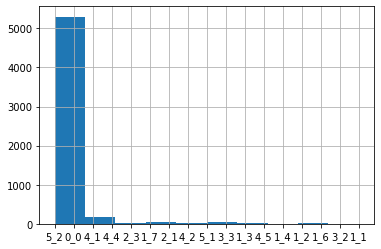

In [45]:
climate_scam_hashtag.roberta_pred.hist()

In [46]:
climate_scam_hashtag[["text", "roberta_pred", "roberta_proba"]]

,text,roberta_pred,roberta_proba
1,@AndrewYang The climate doesn't care \n\n$$$$$$$$$$$$$$$$$$\n\n#ClimateScam,5_2,0.999428
3,*\nholy crap...this man is a national treasure...\n\njust a reminder - he wanted the military to come in and force-vaxx you...\n\n***\n\n#jailfauci\n#neverforgetthesepeople\n#ClimateScam\n#jimcramer\n#endthefed\n#endthemandates\n#trudeaumustgo\n\nhttps://t.co/weL0wQgn6v,0_0,0.998213
5,@826Maureen Funny how anyone against the #ClimateCult #ClimateScam who had a relative who worked for an oil company four generations ago is pilloried as being on the take yet this one literally worked for them for years and crickets!,5_2,0.999388
6,#GretaThunberg is a phony. @GretaThunberg why did you delete this? When’s your next arrest performance scheduled?#ClimateScam https://t.co/L7z0j9HRXC,5_2,0.999465
8,"@12bichonlvr @MikeHudema And not very bright either! Recently God dumped a ton of snow on Cali, just to make fools of the so called wise. So much for that so called global warming #ClimateScam hey:)",5_2,0.998581
...,...,...,...
7281,"Black History must now include Asian people. Native American History Month must now be on the same day as Thanksgiving... Woke is a joke, socialism is the enemy. #climatescam https://t.co/F6p6pXbnPI",0_0,0.999668
7282,"@CBCNews Sounds like something Al Gore would say. The oceans are boiling... \nSuch a farce. How much is the gov't paying you? So lies for gain then, huh? \n\n#ClimateScam\n\nRedirection from gov't corruption.",5_2,0.999461
7283,@POTUS Democrats cheat\n\n#ClimateScam \n\nleave our healthcare alone \n\nstay out of our schools\n\nyour doj is unjust\n\ndignity? #whereshunter,5_2,0.638058
7284,"Worked on my #ClimateScam ""carbon footprint"" yesterday. https://t.co/N7yub593rN",0_0,0.992181


In [47]:
climate_scam_hashtag.loc[
    climate_scam_hashtag.roberta_pred=="0_0", ["text", "roberta_pred", "roberta_proba"]].sample(10)

,text,roberta_pred,roberta_proba
192,#Agenda2030 #WEF #GreatReset 🤡🤡🤡\n\n#ClimateScam Onteigen #TriStateCity Kartelpolitiek. \n\n#Verkiezingen15maart #stemzeweg\n#WEFpuppet's #SorosGang #NietMijnRegering \nhttps://t.co/pfcG9efP6m\nhttps://t.co/lIpvelxjlv\nhttps://t.co/xopIaF80Xs\nhttps://t.co/RLrq2XpZ8o https://t.co/kYi5EwQbD7 https://t.co/a1GS8PHNOC,0_0,0.714459
5055,Dutch Farmers DEFEATED By Net Zero Government 😡 😢 https://t.co/pjCMqx8wYd via @YouTube #dutchfarmers #ClimateScam,0_0,0.782301
303,"@Rainmaker1973 Nice. The only danger to posting math formulas on Twitter is that math is denier kryptonite. #ClimateScam trolls &amp; #antivaxxers run when they see math in response to their lies.\n\n#ClimateCrisis #ClimateEmergency - use math, wound a troll is a win-win #ClimateBrawl",0_0,0.839344
6122,New Climate News: \n\nLufthansa advert ‘protecting’ the planet banned over misleading environmental claims\n\n#climatecrisis #climateaction #esg #carbon #sustainability #netzero #climatescam #globalwarming #climatechange\nhttps://t.co/jh9gE67zpn,0_0,0.997061
2961,"Let’s not forget that we are still going to be using “fossil fuels” anyways, we are just going to be paying more for them #carbontax\n#climatescam #climatecommies https://t.co/4mkmR7MMWg",0_0,0.995826
6777,"@HillierVe3teh @canadian_girl_6 Your reasoning also applies if you're voting for #PierrePussylievre in your revenge to oust Dear Leader.\n\n#votePPC for the platform, &amp; if you compare to the CPC platform, you'll see they will not stop the insane globalist, #climatescam, Digital ID/$ &amp; Marxist DEI policies.",0_0,0.999656
6233,"New Climate News: \n\nEurope: Warm start to 2023 breaks records and skiers’ hearts, says WMO\n\n#climatecrisis #climateaction #esg #carbon #sustainability #netzero #climatescam #globalwarming #climatechange\nhttps://t.co/Z03CMUd69E",0_0,0.999622
7073,"""Pour que la moitié de l'énergie mondiale passe aux énergies renouvelables, l'extraction du lithium devrait augmenter de 2700 %. Le lithium nécessite 500 000 gallons d'eau pour produire une seule tonne. La création de l'énergie ""propre"" est un désastre écologique.""\n#ClimateScam https://t.co/qHVDGNXb0E",0_0,0.931903
482,#Agenda2030 #WEF #GreatReset 🤡🤡🤡\n\n#ClimateScam Onteigen #TriStateCity Kartelpolitiek. \n\n#Verkiezingen15maart #stemzeweg\n#WEFpuppet's #SoroGang #NietMijnRegering \nhttps://t.co/pfcG9efP6m\nhttps://t.co/lIpvelxjlv\nhttps://t.co/xopIaF80Xs\nhttps://t.co/RLrq2XpZ8o https://t.co/0yEubaMQr1 https://t.co/V6zSFJlF80,0_0,0.802835
3505,New Climate News: \n\nGuterres announces ‘no nonsense’ climate action summit; calls for practical solutions\n\n#climatecrisis #climateaction #esg #carbon #sustainability #netzero #climatescam #globalwarming #climatechange\nhttps://t.co/5IrUlvAat7,0_0,0.999616


In [48]:
results['roberta_preprocessed'] = results["text"].astype(str).apply(denoise_text)
predictions, raw_outputs = roberta_model.predict(list(results.roberta_preprocessed))
results['roberta_pred'] = le.inverse_transform(predictions)
results['roberta_proba'] = [max(softmax(element[0])) for element in raw_outputs]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [49]:
results[["text", "roberta_pred", "roberta_proba"]]

,text,roberta_pred,roberta_proba
0,Press coverage of the tragic whale deaths is an attempt to exonerate offshore wind development. Sonar blasting is killing whales indirectly by inducing deafness &amp; deadly behavior. More whales have found themselves in the path of more ships. Whales aren't born deaf. #climatescam,4_1,0.878605
1,"@MOLLYMMMMMMMMMM Love the Plymouth Rock story. 400 + years since the Pilgrims &amp; it's still there, not underwater, reminding people to go down the block &amp; see where Bert's Restaurant got flooded out by a Nor'easter. Bert's had good food but didn't survive the storm. Plymouth Rock did. #climatescam",0_0,0.999690
2,The Washington Post asserted that climate change had reduced Colorado River flow &amp; was drying up reservoirs like Lake Powell &amp; Lake Mead. The River's inflows haven't changed since 1895. These levels &amp; flow issues are due to overuse. WAPO people want $. SCAM! #climatescam,0_0,0.463737
3,"July 2021: London got a month’s rain in 3 hours. 2 weeks later, it happened again. The Univ. of Bristol blamed climate change &amp; predicted 100 years of floods. Nov. 2022: they said ""Due to CO2 emissions, the UK &amp; the globe have increased hot, dry conditions."" Really? #climatescam",5_2,0.922899
4,"Texas leads the U.S. with wind power, is 2nd with solar capacity, &amp; is adding grid-scale batteries faster than any state (ex CA). New plants must prove that they add to the network. TX permits quickly, but renewables cost $. The price for guarantees = + $3 Bil. Ouch! #climatescam",4_4,0.920983
5,"Exxon announced Biofuel is out, leaving carbon capture &amp; storage (CCS) as the “green” strategy at ExxonMobil. Reason: algae doesn't work. The end of algae as a crude oil substitute comes after $350 million &amp; 14 years of commitment. Exxon is committed to oil &amp; gas. #climatescam",0_0,0.963267
6,"Global SUV sales increased despite obstacles &amp; rising inflation, growing by 3% between 2021 &amp; 2022. In 2022, SUVs = 46% of global car sales. Most growth came in the U.S., India and Europe. EVs = 16% of total SUV sales in '22. Greenies: don't tell us what to drive! #climatescam",0_0,0.999645


In [50]:
file = "../Twitter_scrapped/@ClimateScam_CARDS_predictions_{}.csv".format(today)
climate_scam_hashtag.to_csv(file)

### CTTs

In [51]:
tweets['roberta_preprocessed'] = tweets["text"].astype(str).apply(denoise_text)

In [52]:
predictions, raw_outputs = roberta_model.predict(list(tweets.roberta_preprocessed))

  0%|          | 0/7578 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

In [53]:
tweets['roberta_pred'] = le.inverse_transform(predictions)
tweets['roberta_proba'] = [max(softmax(element[0])) for element in raw_outputs]

In [54]:
# tweets = pd.read_csv("@Twitter_CTTs_predictions.csv")
tweets.roberta_pred.value_counts().to_frame().head()

,roberta_pred
0_0,7465
5_2,83
4_1,26
1_4,1
1_2,1


In [55]:
tweets[tweets.referenced_tweets.isna()].shape

(781, 18)

<AxesSubplot:>

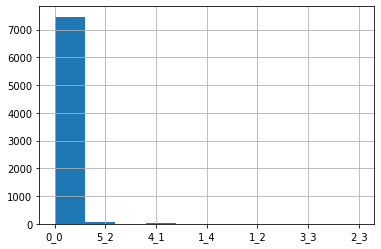

In [56]:
tweets.roberta_pred.hist()

In [57]:
tweets[["text", "roberta_pred", "roberta_proba"]].sample(5)

,text,roberta_pred,roberta_proba
4745,@BaddCompani @Heritage They seemed to all have cashed out of crypto and are now pushing \nbuying gold.,0_0,0.999446
1104,@Rossputin @WalshFreedom @CatoInstitute How far back do we need to go⁉️ \nhttps://t.co/U0apU9fATg,0_0,0.999768
5838,"@Heritage Alternative facts you’ve got here. The budget will reduce deficit 3 trillion over 10 years. Are you in the top tier getting taxed? NO, you’re a fuc&amp;ing foundation. Stop pissing on people.",0_0,0.999563
6682,"Tucker Carlson, with video provided by Speaker McCarthy, falsely depicts Jan. 6 riot a peaceful gathering #SmartNews ⁦@SpeakerMcCarthy⁩ ⁦@GOPMajorityWhip⁩ You damn fool Kevin. ⁦@HouseGOP⁩ ⁦@FoxNews⁩ ⁦@Heritage⁩ ⁦@AFPhq⁩ https://t.co/h3TStBaUEG",0_0,0.999478
4875,@TimKennedyJr1 @Heritage @DailySignal https://t.co/Vp1zSqdaAm,0_0,0.999798


In [58]:
tweets.loc[tweets.roberta_pred!="0_0", ["text", "roberta_pred", "roberta_proba"]].sample(5)

,text,roberta_pred,roberta_proba
5469,@Heritage @AndyPuzder The Heritage Foundation is not a serious news org. They are funded and controlled by extreme pro GOP sources.\nFuck your lies.,5_2,0.988215
6715,@prairiegale @Heritage Jim got busted lying about there being dozens of whistleblowers. There are 3 and one quit in 1999 and another in 2009.. plus they are paying whistleblowers to money to testify! Jim Jordan is a disgrace https://t.co/6lxmsL1EXg,5_2,0.508799
1643,@VP @sashadigiulian @RepPettersen @POTUS @WHO @wef #Agenda2030 #ClimateScam #climate lies. #ClimateEmergency lies. \n@UNFCCC @CFACT educate yourselves. \nPeddling this 💩since 1960's. #China #CO2 \n@ClimateEnvoy @JohnKerry\n us peons should eat bugs and live in caves. https://t.co/sl3GUMWRjt,5_2,0.999463
2510,"@CigmanF @thehipi @cspanwj @StephenMoore @FreedomWorks Extending Trump tax cuts ('TCJA' or #GOPTaxScam) after 2025 would cost $2.2T through 2032; extending its business tax provisions would increase that cost to $2.7T. [CBO, May 2002] Remember only way it passed was to have a built in expiration, because estimated cost was $1.5T+.",4_1,0.986852
3986,@Heritage Heritage Foundation is a Cult of Grifters!! Protect your children from the Heritage Foundation!!,5_2,0.997899


In [59]:
file_CTT = "../Twitter_scrapped/@Twitter_CTTs_predictions_{}.csv".format(today)
tweets.to_csv(file_CTT)

In [60]:
# samples = (
#     tweets.groupby("roberta_pred")
#     .sample(10, replace=True)[["text", "roberta_pred", "roberta_proba"]]
#     .drop_duplicates("text")
# )
# samples.to_csv("@Twitter_CTTs_predictions_samples.csv")

### Denials

In [61]:
tweets_denials['roberta_preprocessed'] = tweets_denials["text"].astype(str).apply(denoise_text)
predictions, raw_outputs = roberta_model.predict(list(tweets_denials.roberta_preprocessed))

  0%|          | 0/7578 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

In [62]:
tweets_denials['roberta_pred'] = le.inverse_transform(predictions)
tweets_denials['roberta_proba'] = [max(softmax(element[0])) for element in raw_outputs]

In [63]:
# tweets_denials = pd.read_csv("@Twitter_Denials_predictions.csv")

In [64]:
tweets_denials.roberta_pred.value_counts().to_frame().head()

,roberta_pred
0_0,7465
5_2,83
4_1,26
1_4,1
1_2,1


<AxesSubplot:>

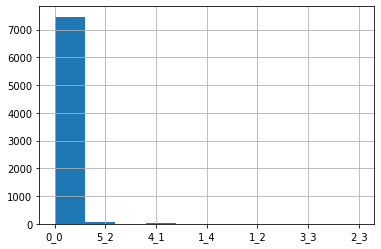

In [65]:
tweets_denials.roberta_pred.hist()

In [66]:
tweets_denials[["text", "roberta_pred", "roberta_proba"]].sample(5)

,text,roberta_pred,roberta_proba
7246,"@realchrisrufo @ManhattanInst @jordanbpeterson @firsthalfofjoeroganpodcast#menthols@stiizy @zanuhdru because i neverfollow anyone and am the follower of followers, fuckers and faggots!! https://t.co/6qUHSO70os",0_0,0.999446
4873,@WesSnyder2187 @TimKennedyJr1 @Heritage @DailySignal Wes Snyder i agree with you a 45 in right place and no more problem. They need to go to Kansas and try that shit. Don't know here who is carrying and most will bang bang you.,0_0,0.999797
6427,@vofitserov_r @kograt @Heritage https://t.co/ZEWzyc8HV3,0_0,0.999804
6931,@HudsonInstitute @mikepompeo @milesyu10 @wshirleyiv @committeeonccp Time to open your windows n doors for fresh air n thinking. This tunnel vision is bad n dangerous.,0_0,0.999766
4558,@Heritage Right is right \none would wish left was left behind,0_0,0.999776


In [67]:
tweets_denials.loc[tweets_denials.roberta_pred!="0_0", ["text", "roberta_pred", "roberta_proba"]].sample(5)

,text,roberta_pred,roberta_proba
5359,@Heritage @AndyPuzder Just more lies from @Heritage - they want to destroy the country with lies.,5_2,0.538971
3740,"@jasonthayes @jlakely @HeartlandInst Jason Hayes: how disappointing that you consider intentionally misleading and lying to people about the science of climate change is ""great work"". Great work based on what standards exactly?",5_2,0.995555
2790,@FreedomWorks Green deal energy is a way for Democrats to control America.. dangerous path…,4_1,0.962494
6495,@kograt Organization that denies that human activity produces CO2 can’t possible had any credibility. They deny climate change for one reason only: they want to dig and sell more oil. Deny this @Heritage: https://t.co/tdiZZpHxGI,5_2,0.982402
3614,@StephenMoore @FreedomWorks I want a refund of my tax dollars for this climate spending SCAM!!!,5_2,0.999023


In [68]:
file_denials = "../Twitter_scrapped/@Twitter_Denials_predictions_{}.csv".format(today)
tweets_denials.to_csv(file_denials)

In [69]:
samples = (
    tweets_denials.groupby("roberta_pred")
    .sample(10, replace=True)[["text", "roberta_pred", "roberta_proba"]]
    .drop_duplicates("text")
)
samples.to_csv("@Twitter_Denials_predictions_samples.csv")